In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from sklearn import preprocessing as prep
from sklearn import tree
from sklearn import linear_model as lm
from sklearn import feature_extraction as feat
from sklearn import feature_selection as fs
from sklearn import model_selection as cv
from sklearn import metrics
from sklearn import ensemble
from sklearn import naive_bayes as nb
from sklearn import svm
from sklearn.pipeline import Pipeline

In [4]:
dfTrain = pd.read_csv('data/train.csv', index_col='id')
dfTest = pd.read_csv('data/test.csv', index_col='id')


with open('cols.yaml', 'r') as fin:
    cols = yaml.safe_load(fin)
bin_cols = cols['binary']
cat_cols = cols['nominal']
ord_cols = cols['ordinal']
num_cols = cols['ratio']

cols = bin_cols + cat_cols + ord_cols + num_cols

#### Work - change below this

(array([584.,  23.,  10.,   6.,   3.,   6.,   5.,   4.,   2.,   3.]),
 array([0.00026337, 0.02512333, 0.04998329, 0.07484325, 0.09970321,
        0.12456317, 0.14942314, 0.1742831 , 0.19914306, 0.22400302,
        0.24886298]),
 <BarContainer object of 10 artists>)

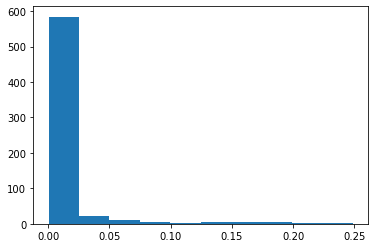

In [9]:
xBin = dfTrain[bin_cols].values

ohe = prep.OneHotEncoder(sparse=False)
xCat = ohe.fit_transform(dfTrain[cat_cols].values)

xBernoulli = np.c_[xBin, xCat]
plt.hist(xBernoulli.var(axis=0))

In [11]:
# Too much low variance Bernoulli features

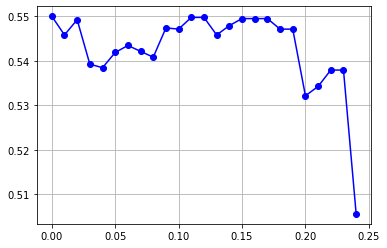

In [28]:
THRESHOLDS = np.arange(0, 0.25, 0.01)
scores = []

for thresh in THRESHOLDS:
    vt = fs.VarianceThreshold(threshold=thresh)
    xBin_high_var = vt.fit_transform(xBernoulli)
    score = cv.cross_val_score(nb.BernoulliNB(), xBin_high_var, dfTrain['label'].values).mean()
    scores.append(score)
plt.plot(THRESHOLDS, scores, '-bo')
plt.grid()

In [29]:
# Looks like 0.12 is a good value
vt = fs.VarianceThreshold(threshold=0.12)
xBin_high_var = vt.fit_transform(xBernoulli)
score = cv.cross_val_score(nb.BernoulliNB(), xBin_high_var, dfTrain['label'].values).mean()
score

0.5497909298939048

#### Look at the ratios with LogisticRegression

In [33]:
xNum = dfTrain[num_cols].values

scaler = prep.StandardScaler()
xNumScaled = scaler.fit_transform(xNum)

cv.cross_val_score(lm.LogisticRegression(max_iter=1000), xNumScaled, dfTrain['label'].values)

array([0.49342105, 0.49011858, 0.49802372, 0.48353096, 0.48616601])

In [32]:
_.mean()

0.4902520629637334

In [41]:
# Combine the two and check
for trix, tsix in cv.StratifiedKFold(shuffle=True).split(dfTrain.values, dfTrain['label'].values):
    
    x_bnb_tr, x_bnb_ts = xBin_high_var[trix], xBin_high_var[tsix]
    x_num_tr, x_num_ts = xNumScaled[trix], xNumScaled[tsix]
    y_tr, y_ts = dfTrain['label'].values[trix], dfTrain['label'].values[tsix]
    
    bnb = nb.BernoulliNB().fit(x_bnb_tr, y_tr)
    lr = lm.LogisticRegression(max_iter=1000).fit(x_num_tr, y_tr)
    p1 = bnb.predict_proba(x_bnb_ts)
    p2 = lr.predict_proba(x_num_ts)
    vote = (p1 + p2) / 2
    pred = np.argmax(vote, axis=1)
    print(metrics.accuracy_score(y_ts, pred))

0.5342105263157895
0.5296442687747036
0.5296442687747036
0.5546772068511199
0.52832674571805


In [45]:
# Throw a DecisionTree in the mix

In [47]:
for trix, tsix in cv.StratifiedKFold(shuffle=True).split(dfTrain.values, dfTrain['label'].values):
    
    x_bnb_tr, x_bnb_ts = xBin_high_var[trix], xBin_high_var[tsix]
    x_num_tr, x_num_ts = xNumScaled[trix], xNumScaled[tsix]
    x_ord_tr, x_ord_ts = dfTrain[ord_cols].values[trix], dfTrain[ord_cols].values[tsix]
    y_tr, y_ts = dfTrain['label'].values[trix], dfTrain['label'].values[tsix]
    
    bnb = nb.BernoulliNB().fit(x_bnb_tr, y_tr)
    lr = lm.LogisticRegression(max_iter=1000).fit(x_num_tr, y_tr)
    dt = tree.DecisionTreeClassifier().fit(x_ord_tr, y_tr)
    
    p1 = bnb.predict_proba(x_bnb_ts)
    p2 = lr.predict_proba(x_num_ts)
    p3 = dt.predict_proba(x_ord_ts)
    vote = (p1 + p2 + p3) / 3
    pred = np.argmax(vote, axis=1)
    print(metrics.accuracy_score(y_ts, pred))

0.6276315789473684
0.6482213438735178
0.6297760210803689
0.6600790513833992
0.6258234519104084


In [50]:
# Try RFC for all features?

for trix, tsix in cv.StratifiedKFold(shuffle=True).split(dfTrain.values, dfTrain['label'].values):
    
    x_bnb_tr, x_bnb_ts = xBin_high_var[trix], xBin_high_var[tsix]
    x_num_tr, x_num_ts = xNumScaled[trix], xNumScaled[tsix]
    x_ord_tr, x_ord_ts = dfTrain[ord_cols].values[trix], dfTrain[ord_cols].values[tsix]
    y_tr, y_ts = dfTrain['label'].values[trix], dfTrain['label'].values[tsix]
    
    xTr = np.c_[x_bnb_tr, x_num_tr, x_ord_tr]
    xTs = np.c_[x_bnb_ts, x_num_ts, x_ord_ts]
    rfc = ensemble.RandomForestClassifier().fit(xTr, y_tr)
    pred = rfc.predict(xTs)
    
    
    print(metrics.accuracy_score(y_ts, pred))

0.725
0.7351778656126482
0.7285902503293807
0.7378129117259552
0.7430830039525692


In [51]:
# This seems to work well... Try submitting one based on this
X = np.c_[xBin_high_var, xNumScaled, dfTrain[ord_cols].values]
y = dfTrain['label'].values

grid = {
    'n_estimators': [10, 50, 100, 200, 500],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample', None]
}
rfc = ensemble.RandomForestClassifier()
gcv = cv.GridSearchCV(rfc, param_grid=grid, verbose=2, n_jobs=-1, refit=True)
gcv.fit(X, y)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


/home/jaidevd/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jaidevd/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jaidevd/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "/home/jaidevd/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/jaidevd/conda/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/jaidevd/conda/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample',
                                          None],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [10, 50, 100, 200, 500]},
             verbose=2)

In [52]:
gcv.best_score_

0.7418292767491852

In [53]:
gcv.best_params_

{'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_features': 'sqrt',
 'n_estimators': 200}

In [55]:
ohe.handle_unknown = 'ignore'

xBin_test = dfTest[bin_cols].values

# ohe = prep.OneHotEncoder(sparse=False)
xCat_test = ohe.transform(dfTest[cat_cols].values)

xBernoulli_test = np.c_[xBin_test, xCat_test]
xBin_high_var_test = vt.transform(xBernoulli_test)

xNumScaled_test = scaler.transform(dfTest[num_cols].values)

Xts = np.c_[xBin_high_var_test, xNumScaled_test, dfTest[ord_cols].values]


prediction = gcv.best_estimator_.predict(Xts)
prediction

array([1, 1, 1, ..., 0, 0, 0])

In [58]:
pd.Series(prediction).value_counts(normalize=True)

1    0.627764
0    0.299140
2    0.073096
dtype: float64

In [60]:
dfTrain['label'].value_counts(normalize=True)

1    0.49078
0    0.32745
2    0.18177
Name: label, dtype: float64

In [62]:
sub = pd.read_csv('data/sample.csv')
sub['label'] = prediction
sub.to_csv('data/submission4.csv', index=False)